### Device Configuration & Reproducibility

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU: Tesla T4


In [2]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib seaborn scikit-learn tqdm kaggle

### Imports & Environment Setup

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


### Dataset Download / Loading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salviohexia/isic-2019-skin-lesion-images-for-classification")

print("Path to dataset files:", path)

100%|██████████| 9.10G/9.10G [03:59<00:00, 40.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/versions/1


### Dataset Inspection

In [3]:
import os

print(path)
print("\nFiles/folders inside dataset:\n")
for item in os.listdir(path):
    print(item)


/root/.cache/kagglehub/datasets/salviohexia/isic-2019-skin-lesion-images-for-classification/versions/1

Files/folders inside dataset:

BKL
NV
DF
BCC
SCC
MEL
ISIC_2019_Training_GroundTruth.csv
AK
ISIC_2019_Training_Metadata.csv
VASC


### Class Selection & Dataset Filtering

In [4]:
import shutil
import os

BASE_DATASET_DIR = "/content/isic_selected"
os.makedirs(BASE_DATASET_DIR, exist_ok=True)

selected_classes = ["MEL", "NV", "BCC", "BKL"]

for cls in selected_classes:
    src = os.path.join(path, cls)
    dst = os.path.join(BASE_DATASET_DIR, cls)
    shutil.copytree(src, dst)

print("Selected classes copied successfully.")


Selected classes copied successfully.


### Image Transformations & Augmentation

In [5]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
from torchvision.datasets import ImageFolder

full_dataset = ImageFolder(
    root=BASE_DATASET_DIR,
    transform=train_transforms
)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))


Classes: ['BCC', 'BKL', 'MEL', 'NV']
Total images: 23344


### Configuration

In [ ]:
import torch
import numpy as np

SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4


### Dataset Splitting

In [10]:
from torch.utils.data import random_split

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Important: override transforms for val/test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 16340
Validation size: 3501
Test size: 3503


### DataLoader Creation

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


In [12]:
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)
print("Sample labels:", labels[:10])


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Sample labels: tensor([2, 3, 3, 3, 3, 3, 3, 3, 3, 0])


### Model Definition (EfficientNet)

In [13]:
import torch.nn as nn
from torchvision import models

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier head
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4)  # 4 classes

# Move model to GPU
model = model.to(DEVICE)

print("Model loaded and moved to device:", DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]


Model loaded and moved to device: cuda


### Loss Function & Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

### Training Function

In [15]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### Validation Function

In [16]:
def validate(model, loader, criterion):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### Training Loop

In [17]:
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✔ Best model saved")



Epoch 1/15
------------------------------
Train Loss: 0.7095 | Train Acc: 0.7259
Val   Loss: 0.5257 | Val   Acc: 0.7992
✔ Best model saved

Epoch 2/15
------------------------------
Train Loss: 0.4718 | Train Acc: 0.8179
Val   Loss: 0.4632 | Val   Acc: 0.8275
✔ Best model saved

Epoch 3/15
------------------------------
Train Loss: 0.3345 | Train Acc: 0.8747
Val   Loss: 0.4416 | Val   Acc: 0.8403
✔ Best model saved

Epoch 4/15
------------------------------
Train Loss: 0.2426 | Train Acc: 0.9100
Val   Loss: 0.4566 | Val   Acc: 0.8478
✔ Best model saved

Epoch 5/15
------------------------------
Train Loss: 0.1723 | Train Acc: 0.9382
Val   Loss: 0.4826 | Val   Acc: 0.8506
✔ Best model saved

Epoch 6/15
------------------------------
Train Loss: 0.1324 | Train Acc: 0.9517
Val   Loss: 0.5157 | Val   Acc: 0.8466

Epoch 7/15
------------------------------
Train Loss: 0.1011 | Train Acc: 0.9641
Val   Loss: 0.5412 | Val   Acc: 0.8446

Epoch 8/15
------------------------------
Train Loss: 0.0

In [18]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

print("Best model loaded for test evaluation.")

Best model loaded for test evaluation.


### Test Evaluation

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
test_prec = precision_score(all_labels, all_preds, average="weighted")
test_rec = recall_score(all_labels, all_preds, average="weighted")
test_f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

Test Accuracy : 0.8578
Test Precision: 0.8547
Test Recall   : 0.8578
Test F1-score : 0.8550


### Confusion Matrix

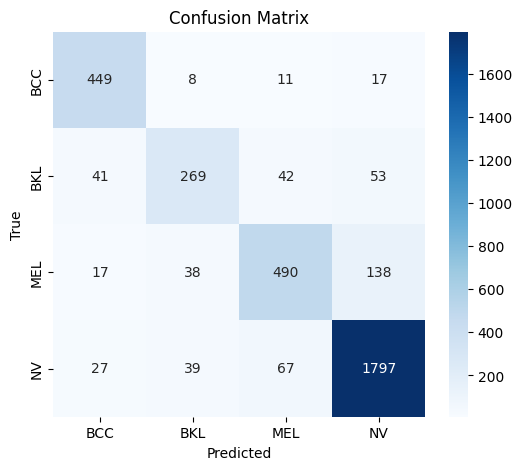

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=full_dataset.classes,
    yticklabels=full_dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Grad-CAM Class Definition

In [21]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

### Grad-CAM Visualization on Sample Images

In [22]:
import cv2
import numpy as np

# Get one test sample
img_tensor, label = test_dataset[0]

input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

In [23]:
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

cam = gradcam.generate(input_tensor)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


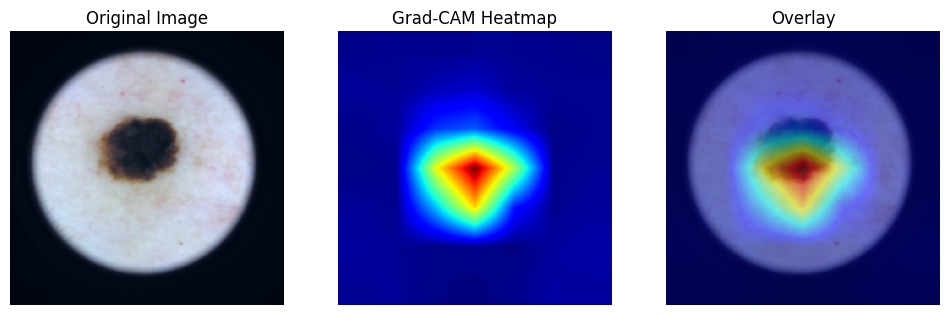

In [24]:
# Convert tensor to image
img = img_tensor.permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.5 * img + 0.5 * heatmap

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cam_resized, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

### Cells to test the backend by browsing an image from device and testing the predictions, simpple interaction with proagram apart from Streamlit frontend 

In [31]:
from google.colab import files
uploaded = files.upload()

Saving ISIC_0024331.jpg to ISIC_0024331.jpg


In [32]:
from PIL import Image

# Get uploaded image
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")

# Apply same transforms
input_tensor = val_test_transforms(image).unsqueeze(0).to(DEVICE)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_class = probs.argmax(dim=1).item()
    confidence = probs.max().item()

class_names = full_dataset.classes
print(f"Predicted Lesion: {class_names[pred_class]}")
print(f"Confidence: {confidence:.2f}")

Predicted Lesion: BCC
Confidence: 0.92


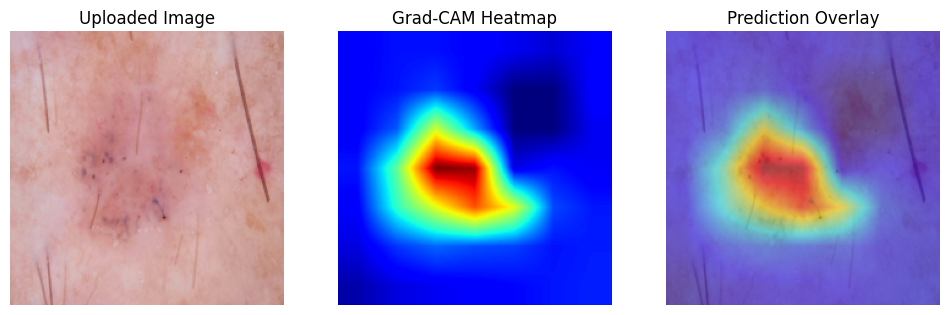

In [33]:
cam = gradcam.generate(input_tensor)

img_np = np.array(image.resize((224,224))) / 255.0
cam_resized = cv2.resize(cam, (224,224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.5 * img_np + 0.5 * heatmap

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Uploaded Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cam_resized, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()